# Data Import

In [ ]:
# Install all requirements for the code
!pip install -q opendatasets
!pip install -q tensorflow_text
!pip install -q transformers

In [2]:
# Download the dataset from Kaggle
import opendatasets as od
od.download("https://www.kaggle.com/Cornell-University/arxiv?select=arxiv-metadata-oai-snapshot.json")

100%|██████████| 1.04G/1.04G [00:58<00:00, 19.2MB/s]


# Data Preparation

In [8]:
# Data Import
import json
import pandas as pd
import opendatasets as od

# Data Preparation
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Model
import tensorflow as tf
import torch

In [9]:
# Get the data
data_arxiv = './arxiv/arxiv-metadata-oai-snapshot.json'

In [ ]:
NUM_ARTICLES = 15000 # We only choose a subset of 1.7 million articles in data_arxiv
# Create a pandas dataframe
arxiv_x = pd.DataFrame(columns=['abstract'])
cats2 = ['Computer Science','Math','Physics','Quant. Bio','Statistics']
arxiv_y = pd.DataFrame(columns=cats2)
counts = [0,0,0,0,0]
cats = ['cs.','math.','ph','q-bio.','stat.']
done = False
with open(data_arxiv) as f:
  # Read through each article
  nextline = f.readline()
  while not done and nextline:
    # Add the article to the dataframe
    line = json.loads(nextline)
    cat = line['categories']
    res = [ele for ele in cats if ele in cat]
    if len(res) == 1:
      ind = cats.index(res[0])
      if counts[ind] < 3000:
        arr = [0 for i in range(5)]
        arr[ind] = 1
        arxiv_x = arxiv_x.append({'abstract': line['abstract']}, ignore_index=True)
        arxiv_y = arxiv_y.append({'Computer Science':arr[0], 'Math':arr[1],'Physics':arr[2],'Quant. Bio':arr[3],'Statistics':arr[4]}, ignore_index=True)
        counts[ind] += 1

        if sum(counts) >= NUM_ARTICLES:
          done = True
    nextline = f.readline()
print(counts)

In [11]:
arxiv_x

,abstract
0,A fully differential calculation in perturba...
1,We show that a determinant of Stirling cycle...
2,In this paper we show how to compute the $\L...
3,We discuss the results from the combined IRA...
4,Partial cubes are isometric subgraphs of hyp...
...,...
14995,The concept of refinement from probability e...
14996,This paper introduces a spatio-temporal reso...
14997,The joint modeling of longitudinal and time-...
14998,Background: Recent studies have shown a decr...


In [12]:
#  This function will remove all the occurrences of newlines, tabs, and combinations like \\n.
def remove_newlines_tabs(text):
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ')
    return Formatted_text
    
arxiv_x = arxiv_x.applymap(remove_newlines_tabs)

In [13]:
# Split Data into training and testing subsets (stratify by arxiv_y)
x_train, x_test, y_train, y_test = train_test_split(arxiv_x,arxiv_y,test_size = 0.2, stratify = arxiv_y)

In [14]:
# convert y_train from pd.dataframe to np.ndarray to fit the model.fit() format requirement
y_train = np.asarray(y_train).astype(np.int32)
y_test = np.asarray(y_test).astype(np.int32)

# Model 1: LSTM
Reference: https://www.tensorflow.org/text/tutorials/text_classification_rnn

## Build and Train LSTM Model

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


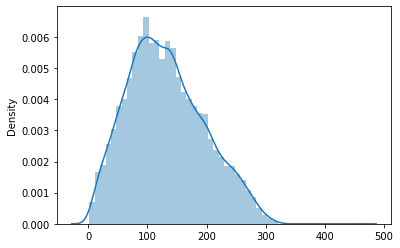

In [ ]:
lengths = []
for i in range(x_train.values.shape[0]):
  lengths.append(len(x_train['abstract'].values[i].split()))

sns.distplot(lengths) 
# From the plot we can see most sentences have length less than 250. Therefore, we will set MAX_SEQUENCE_LENGTH = 250

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (each word appears at least five times in the following tokenizer)
MAX_NB_WORDS = 14500
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# Words will be embedded into 30 dimensional space.
EMBEDDING_DIM = 30

# we customize the filters here such that mathematical operations (such as addition and exponent are kept)
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$&()\,.:;?@[]_`{|}~', lower=True)
tokenizer.fit_on_texts(x_train['abstract'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

lst_cnt = list(tokenizer.word_counts.values())
lst_cnt = [x for x in lst_cnt if x > 4]
print('Found %s unique tokens appearing at least five times.' % len(lst_cnt))

Found 57858 unique tokens.
Found 14327 unique tokens appearing at least five times.


In [ ]:
# tokenizer1 = Tokenizer(num_words=10, filters='!"#$&()\,.:;?@[]_`{|}~', lower=True,char_level=False)
# tokenizer1.fit_on_texts(["This is really really absurb!!! What's this bro?", "It's $haha\Phi's$ I cannot believe that new words are here heihei zebra"])
# tokenizer1.word_index
# tokenizer1.texts_to_sequences(["This is heihei zebra"])

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(x_train['abstract'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12000, 250)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D, Embedding,SpatialDropout1D, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 30
batch_size = 64

history = model.fit(X, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.25,callbacks=[EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)])


Epoch 1/30
141/141 [==============================] - 110s 756ms/step - loss: 1.3396 - accuracy: 0.4087 - val_loss: 0.9938 - val_accuracy: 0.5980
Epoch 2/30
141/141 [==============================] - 108s 763ms/step - loss: 0.7941 - accuracy: 0.7061 - val_loss: 0.7423 - val_accuracy: 0.7427
Epoch 3/30
141/141 [==============================] - 107s 757ms/step - loss: 0.4935 - accuracy: 0.8374 - val_loss: 0.7180 - val_accuracy: 0.7177
Epoch 4/30
141/141 [==============================] - 105s 748ms/step - loss: 0.5282 - accuracy: 0.8227 - val_loss: 0.5709 - val_accuracy: 0.8283
Epoch 5/30
141/141 [==============================] - 105s 748ms/step - loss: 0.3064 - accuracy: 0.9111 - val_loss: 0.5096 - val_accuracy: 0.8440
Epoch 6/30
141/141 [==============================] - 106s 750ms/step - loss: 0.2220 - accuracy: 0.9350 - val_loss: 0.5321 - val_accuracy: 0.8413
Epoch 7/30
141/141 [==============================] - 106s 750ms/step - loss: 0.1538 - accuracy: 0.9581 - val_loss: 0.5010 -

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 30)           435000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 30)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               81408     
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 517,053
Trainable params: 517,053
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Plot the loss in both the train and validation data
def plot_model_history(his):
  plt.title('Loss')
  plt.plot(his.history['loss'], label='train')
  plt.plot(his.history['val_loss'], label='test')
  plt.legend()
  plt.show();

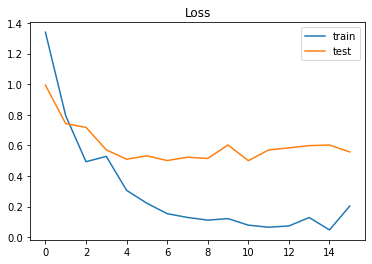

In [ ]:
plot_model_history(history)

## LSTM Result Analysis

In [ ]:
# Evaluate on testing set
X_test = tokenizer.texts_to_sequences(x_test['abstract'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)


print(model.evaluate(X_test, y_test))

94/94 [==============================] - 9s 96ms/step - loss: 0.5177 - accuracy: 0.8617
[0.5177016258239746, 0.8616666793823242]


In [43]:
from sklearn.metrics import confusion_matrix

preds = model.predict(X_test)

In [40]:
def convert_to_prediction(arr):
  index_prediciton = max(enumerate(arr), key=(lambda x: x[1]))[0]
  arr[arr > -1]=0
  arr[index_prediciton] = 1
  return arr


for (i, arr) in enumerate(preds):
  preds[i] = convert_to_prediction(arr)



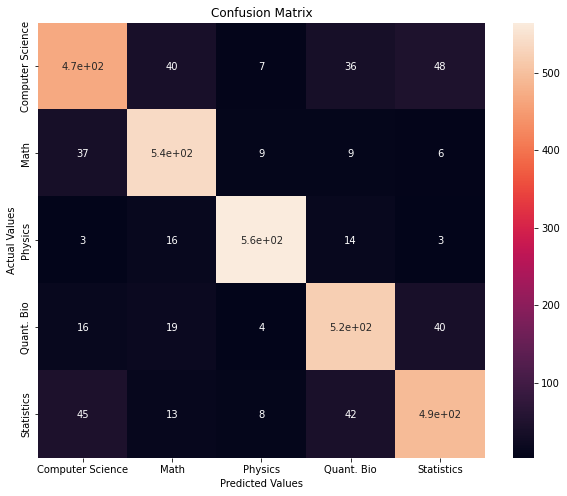

In [ ]:
import sklearn
cm =confusion_matrix(np.dot(y_test, np.array([1,2,3,4,5])), np.dot(preds, np.array([1,2,3,4,5])))
plt.figure(figsize=(10,8))
# plt.figure()
sns.heatmap(cm, annot=True,xticklabels=cats2,yticklabels=cats2)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, preds, target_names=cats2))

                  precision    recall  f1-score   support

Computer Science       0.82      0.78      0.80       600
            Math       0.86      0.90      0.88       600
         Physics       0.95      0.94      0.95       600
      Quant. Bio       0.84      0.87      0.85       600
      Statistics       0.84      0.82      0.83       600

       micro avg       0.86      0.86      0.86      3000
       macro avg       0.86      0.86      0.86      3000
    weighted avg       0.86      0.86      0.86      3000
     samples avg       0.86      0.86      0.86      3000



**Analysis**: 

Overall, LSTM Model has given us around 86% accuracy for the testing subset with 9,000 paper's abstract in total. From the confusion Matrix and the classification report above, we can see Physics paper more sensitive and more precise than the other subjects. Math and Quant. Bio also have decent performance with f1-score over 0.85. On the other hand, Computer Science and Statistics are always mixed up by our model. We assume it's because the strong connections between these two subjects, and we will check misclassified texts to verify our assumption in the following section.

## LSTM Misclassification Analysis

In [ ]:
# Create a new dataframe to analyze the misclassifications
preds = preds.astype('int32')
df_result = pd.DataFrame({
    'text': x_test['abstract'],
    'actual': list(np.dot(y_test, np.array([1,2,3,4,5]))),
    'predicted': list(np.dot(preds, np.array([1,2,3,4,5])))
})


In [ ]:
# Computer Science Paper that are classified as Statistics
df_result[(df_result['actual']==1) & (df_result['predicted']==5)]

,text,actual,predicted
3345,The concept of data depth in non-parametric ...,1,5
9016,The concept of the value-gradient is introdu...,1,5
5086,In the process of training Support Vector Ma...,1,5
8518,Self organizing maps (SOMs) are widely-used ...,1,5
2041,We present a qualitative study of 20 America...,1,5
8294,Data privacy is one of the key challenges fa...,1,5
6133,Evidence-based medicine is critically depend...,1,5
9249,This paper examines the possibility of disco...,1,5
8792,Ontario (Canada) Health System stakeholders ...,1,5
10298,"Trust is often conveyed through delegation, ...",1,5


**Conclusion**:

After analysing the texts that are misclassified as Computer Science (False Positive) or cannot be correctly calssified as Computer Science (False Negative), we conclude that Computer Science has so many overlapping with other fields such as Statistics and mathmatics, so it is a challenging task to give the correct label only based on the abstract. To increase the accuracy, we have changed default filter of tokenizer to let it include mathematical operations (such as multiplication and exponent), and the validation accuracy has increased 3% from around 83% to around 86%. We will try the pretrained DistilBERT Model with its pretrained tokenizer in the following section to test the performance of a more advanced transformer model.

# Tuning a Pre-trained model (DistilBERT)



Reference: [https://huggingface.co/docs/transformers/model_doc/distilbert](https://huggingface.co/docs/transformers/model_doc/distilbert)

We chose DistilBERT as our pretrained model since our original model uses LSTMs, and we wanted to compare the performance of LSTMs to transformers. DistilBERT is also a smaller and faster version of the well known BERT model, so this would allow us to train it more quickly, since it still retains 95% of the accuracy of the original BERT model.

In [5]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, BertForPreTraining

In [15]:
# Convert input into tokenized version for model
def convert_to_tokenization(data):
  inputs = list()
  for index, line in data.iteritems():
    text=str(line)
    inputs.append(text)
  return inputs

# Turn input into single string for tokenization
data = arxiv_x.iloc[:,0]
inputs = convert_to_tokenization(data)


In [16]:
# Convert labels into proper input
def convert_to_labels(data):
  labels = list()
  for index, line in data.iterrows():
    for i, item in enumerate(cats2):
      if line[item] == 1:
        labels.append(i)
  return labels

# Turn labels into sparse targets rather than one-hot encoding
labels = convert_to_labels(arxiv_y)
x_train2, x_test2, y_train2, y_test2 = train_test_split(inputs,labels,test_size = 0.2, stratify = labels)

In [17]:
# Tokenize the input using the DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased") #Tokenizer
tokenized = tokenizer(x_train2, padding=True, truncation=True, return_tensors='tf') #Tokenized text

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 32.3kB/s]
Downloading: 100%|██████████| 483/483 [00:00<00:00, 390kB/s]
Downloading: 100%|██████████| 226k/226k [00:00<00:00, 519kB/s]  
Downloading: 100%|██████████| 455k/455k [00:00<00:00, 848kB/s] 


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-13 14:49:21.713806: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 14:49:21.716639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
# Create a tensorflow dataset for the model
dataset=tf.data.Dataset.from_tensor_slices((dict(tokenized), y_train2))
dataset = dataset.shuffle(len(dataset))
val_data_size=int(0.25*len(dataset))
# Split into validation and training data (Batch size of less than 4 is required otherwise COLAB runs out of RAM)
val_ds=dataset.take(val_data_size).batch(8)
train_ds=dataset.skip(val_data_size).batch(8)

In [33]:
from tensorflow.keras.callbacks import EarlyStopping
# Run the distilbert model
model_bert = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(cats2))
model_bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.SparseCategoricalAccuracy()]
        )
 
history2 = model_bert.fit(train_ds, validation_data = val_ds, epochs=30, verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_159', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use 

Epoch 1/30


2022-05-13 17:20:30.495516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1125/1125 [==============================] - ETA: 0s - loss: 0.4575 - sparse_categorical_accuracy: 0.8693

2022-05-13 17:33:44.544494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1125/1125 [==============================] - 883s 770ms/step - loss: 0.4575 - sparse_categorical_accuracy: 0.8693 - val_loss: 0.2404 - val_sparse_categorical_accuracy: 0.9257
Epoch 2/30
1125/1125 [==============================] - 861s 765ms/step - loss: 0.2343 - sparse_categorical_accuracy: 0.9273 - val_loss: 0.1571 - val_sparse_categorical_accuracy: 0.9530
Epoch 3/30
1125/1125 [==============================] - 862s 766ms/step - loss: 0.1658 - sparse_categorical_accuracy: 0.9500 - val_loss: 0.1070 - val_sparse_categorical_accuracy: 0.9703
Epoch 4/30
1125/1125 [==============================] - 863s 766ms/step - loss: 0.1174 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.0584 - val_sparse_categorical_accuracy: 0.9820
Epoch 5/30
1125/1125 [==============================] - 862s 766ms/step - loss: 0.0785 - sparse_categorical_accuracy: 0.9772 - val_loss: 0.0417 - val_sparse_categorical_accuracy: 0.9883
Epoch 6/30
1125/1125 [==============================] - 862s 766ms/step - loss: 0

As we can see from the training, the model ran for a similar amount of epochs before settling into its top accuracy, which in this case has a validation accuracy of 99%

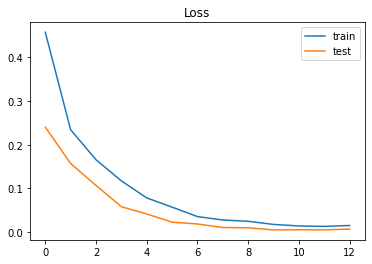

In [36]:
# Check the loss of the distilbert model
plot_model_history(history2)

The loss plot for this model looks a lot smoother than the LSTM model, and the train and test loss curves are a lot more correlated

In [37]:
# Evaluate on testing set
eval_x = tokenizer(x_test2, padding=True, truncation=True, return_tensors='tf') #Tokenized text
eval=tf.data.Dataset.from_tensor_slices((dict(eval_x), y_test2))

# model evaluation on the test set
print(model_bert.evaluate(eval.shuffle(len(x_test2)).batch(4), 
               return_dict=True, 
               batch_size=4))

750/750 [==============================] - 110s 145ms/step - loss: 0.4608 - sparse_categorical_accuracy: 0.9150
{'loss': 0.46079814434051514, 'sparse_categorical_accuracy': 0.9149999618530273}


Our accuracy for this model as measured by the test dataset is about .06 higher than the LSTM model

In [38]:
dataset = tf.data.Dataset.from_tensor_slices(dict(eval_x))
preds_2 = model_bert.predict(dataset.batch(4)).logits  
preds_2 = tf.nn.softmax(preds_2, axis=1).numpy()      

2022-05-14 14:08:35.273911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [41]:
for (i, arr) in enumerate(preds_2):
  preds_2[i] = convert_to_prediction(arr)

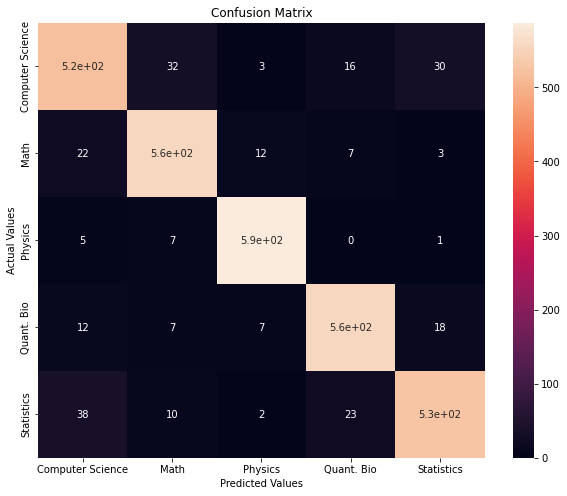

In [44]:
import sklearn
cm =confusion_matrix([i + 1 for i in y_test2], np.dot(preds_2, np.array([1,2,3,4,5])))
plt.figure(figsize=(10,8))
# plt.figure()
sns.heatmap(cm, annot=True,xticklabels=cats2,yticklabels=cats2)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Unlike the LSTM model, this model's largest error rate comes from the missclassification of Statistics papers as Computer Science papers, which is very interesting since the previous model did the opposite. 

In [46]:
from sklearn.metrics import classification_report
y_test2_other = []
for i in y_test2:
    arr = [0]*5
    arr[i] = 1
    y_test2_other.append(arr)
print(classification_report(y_test2_other, preds_2, target_names=cats2))

                  precision    recall  f1-score   support

Computer Science       0.87      0.86      0.87       600
            Math       0.91      0.93      0.92       600
         Physics       0.96      0.98      0.97       600
      Quant. Bio       0.92      0.93      0.93       600
      Statistics       0.91      0.88      0.89       600

       micro avg       0.92      0.92      0.92      3000
       macro avg       0.91      0.92      0.91      3000
    weighted avg       0.91      0.92      0.91      3000
     samples avg       0.92      0.92      0.92      3000



We see that the general distribution fo the precision and recall is the same as the LSTM model, with computer science having the worse precision and physics the best, although this model is a lot more accurate for some of the other fields such as Statistics.

In [47]:
# Create a new dataframe to analyze the misclassifications
preds_2 = preds_2.astype('int32')
df_result_2 = pd.DataFrame({
    'text': x_test2,
    'actual': list([i + 1 for i in y_test2]),
    'predicted': list(np.dot(preds_2, np.array([1,2,3,4,5])))
})


In [49]:
# Statistics Papers that are classified as Computer Science
df_result_2[(df_result_2['actual']==5) & (df_result_2['predicted']==1)]

,text,actual,predicted
109,Many of the early works in the quality contr...,5,1
324,We obtain an index of the complexity of a ra...,5,1
347,Despite the recent progress towards efficien...,5,1
372,"When analyzing interaction networks, it is c...",5,1
472,"In this paper, we analyze the celebrated EM ...",5,1
487,This paper introduces a novel paradigm to im...,5,1
611,"Due to space limitations, our submission ""So...",5,1
775,In the applications related to airborne rada...,5,1
787,Combining forecast from different models has...,5,1
819,Nonnegative matrix factorization (NMF) is no...,5,1


As we can see, a lot of the papers that were missclassified by the model seem to fall under the intersection of computer science and statistics, even though they were only classified as statistics

# Conclusion

Our two models gave us very comparable results on the dataset, with the Transformers model performing slightly better than our LSTM model. This could partially be due to the larger size of the model, as well as the fact that it is a finetuning of a previous existing and very well renowned text classification model (DistilBERT). Thus, our constructed LSTM model performs very well in comparison to the state of the art system. We see in both models that Physics is the most distinguishable of all the fields, while computer science and statistics are harder to identify, and are sometimes comfused with each other, which to anyone who is familiar with those two fields will understand, as there is a large amount of overlap, and also since a lot of scientific fields borrow and use techniques from those two fields. However, accuracies of 86% and 92% are very impressive for a model that is only reading the abstract. We postulate that further research would show that reading the entire scientific paper would probably provide a higher accuracy for either model, as it would provide a lot more context to the transformer model, as well as give more data to train on in the LSTM model.

**Other Models to try later:**

from: https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb#scrollTo=aksj743St9ga

from: https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d

from: https://www.kaggle.com/code/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert#BERT-and-Its-Implementation-on-this-Competition